<a href="https://colab.research.google.com/github/morwald/ada_project/blob/master/gender_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of gender distribution in UK's leading newspapers
# Gender representation

## Content
1. [Setup](#setup)   
    1.1 [Global](#global_setup)  
    1.2 [Local](#local_setup)

## 1. Setup
<a id="setup"></a>

### 1.1 Global
<a id="global_setup"></a>

In [1]:
# Change to true if you want to use google colab
use_colab = True

# Import with EPFL google drive!
if use_colab:
    from google.colab import drive
    drive._mount('/content/drive', force_remount=True)
    %cd /content/drive/Shareddrives/ADA-project
    #!pip install pandas==1.0.5 # downgrade pandas for chunk processing support

Mounted at /content/drive
/content/drive/Shareddrives/ADA-project


In [2]:
# Defined paths for the data
from scripts.path_defs import *

# Defined newspapers and urls
from scripts.newspapers import *

# Globally used functions
from scripts.utility_functions import load_mini_version_of_data
from scripts.utility_functions import convert_to_1Dseries
from scripts.utility_functions import process_data_in_chunks

# Functions and libraries to perform topic analysis
from collections import Counter
from functools import reduce

### 1.2 Local 
<a id="local_setup"></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import bz2
import math
import plotly.graph_objects as go
import plotly.express as px

## Topic analysis set up with empath

TODO : Intro on empath, which year, what it does, why we use it

In [ ]:
! pip install empath

     |████████████████████████████████| 57 kB 2.8 MB/s 
  Created wheel for empath: filename=empath-0.89-py3-none-any.whl size=57821 sha256=7ca7c9fc781ada7830ecb9261f7ce5525069b58c6eb0973e871a1f41179b70e2
  Stored in directory: /root/.cache/pip/wheels/2b/78/a8/37d4505eeae79807f4b5565a193f7cfcee892137ad37591029
Successfully built empath


In [ ]:
from empath import Empath

# Define lexicon
lexicon = Empath()

In [ ]:
# Creation of a category me-too to describe better the feminism event of the last few years
lexicon.create_category("metoo",["metoo","#metoo","consent", "harassment", "sexual assault", "sexual misconduct"], model='nytimes')

["harassment", "consent", "coercion", "notification", "legal_rights", "due_process", "criminal_prosecution", "constitutional_rights", "such_conduct", "abuse", "unlawful", "court_orders", "confidentiality", "sexual_harassment", "illegal_activity", "criminal_proceedings", "misconduct", "violation", "sexual_activity", "sexual_relations", "conduct", "rape_victims", "sanction", "criminal_conduct", "sexual_contact", "recourse", "injunctions", "discrimination", "sexual_orientation", "intimidation", "criminal_activity", "such_practices", "sexual_conduct", "criminal_prosecutions", "mistreatment", "the_Fourth_Amendment", "illegality", "civil_authorities", "sex_discrimination", "federal_laws", "reasonable_suspicion", "disciplinary_actions", "Florida_law", "Miranda_warnings", "complainants", "immigration_status", "privacy_rights", "political_beliefs", "racial_discrimination", "noncompliance", "sex_crimes", "homosexual_conduct", "sexual_intercourse", "preferential_treatment", "parental_consent", "N

### Utility functions

In [ ]:
def add_dict(dict1, dict2):
  counter1 = Counter(dict1)
  counter2 = Counter(dict2) 

  dict_ = dict(counter1 + counter2) 
  
  return dict_

In [ ]:
def get_topics_quote(quote):
  categories = lexicon.analyze(quote, normalize=True)
  return categories

In [ ]:
def get_gender_topics(chunk, gender_topics_df, year):
  raw_df = chunk.copy()[['quotation', 'gender']] # Select rows of interest

  #Add year
  raw_df['year'] = year

  # Group genders
  mask_male = raw_df.gender.apply(lambda x : 'male' in x)
  mask_female = raw_df.gender.apply(lambda x : 'female' in x)
  mask_others = raw_df.gender.apply(lambda x : ('male' not in x) and ('female' not in x))
  
  male_topics_df = raw_df[mask_male]
  female_topics_df = raw_df[mask_female]
  others_topics_df = raw_df[mask_others]

  # Add topics and topics probability per quotation to each gender's dictionary
  male_topics_dict, female_topics_dict, others_topics_dict = {}, {}, {}

  male_topics_dict_list = male_topics_df.quotation.apply(get_topics_quote)
  male_topics_dict = reduce(add_dict,male_topics_dict_list)

  female_topics_dict_list = female_topics_df.quotation.apply(get_topics_quote)
  female_topics_dict = reduce(add_dict,female_topics_dict_list)

  others_topics_dict_list = others_topics_df.quotation.apply(get_topics_quote)
  if others_topics_dict_list.any():
    others_topics_dict = reduce(add_dict,others_topics_dict_list)
  

  # Create final dataframe
  cols = ['year', 'gender', 'topics']
  
  gender_topics_df = pd.DataFrame(columns=cols)
  if bool(male_topics_dict):
    gender_topics_df = gender_topics_df.append(pd.DataFrame([[year, 'male', dict(male_topics_dict)]], columns=cols), ignore_index = True)
  if bool(female_topics_dict):
    gender_topics_df = gender_topics_df.append(pd.DataFrame([[year, 'female', female_topics_dict]], columns=cols), ignore_index = True)
  if bool(others_topics_dict):
    gender_topics_df = gender_topics_df.append(pd.DataFrame([[year, 'others', others_topics_dict]], columns=cols), ignore_index = True)

  return gender_topics_df  

### Example of use

In [ ]:
mini_df_2018 =  load_mini_version_of_data(MERGED_QUOTES_2018_PATH, 10, 2,use_colab)

In [ ]:
mini_df_2018.head()

,quoteID,quotation,speaker,date,numOccurrences,urls,newspapers,qid,gender,nationality,occupation
0,2018-05-29-000378,[ The chances of Bale signing for Manchester U...,Jose Mourinho,2018-05-29 13:12:18,1,[https://www.dailystar.co.uk/sport/football/70...,[Daily Star],Q79983,[male],[Portugal],"[association football manager, association foo..."
1,2018-12-12-000462,"[ The female character in the song ] is sweet,...",Deana Martin,2018-12-12 11:19:56,4,[http://www.completemusicupdate.com/article/de...,[The Daily Telegraph],Q17305837,[female],[United States of America],"[jazz musician, television actor, film actor]"
2,2018-12-09-000490,A Christmas box!!!!! All our fav things.. CHRI...,Nicola Wilson,2018-12-09 10:54:34,2,[https://www.dailyrecord.co.uk/news/scottish-n...,"[Daily Record, Daily Mirror]",Q441340,[female],[United Kingdom],[event rider]
3,2018-06-26-001361,A friend has raised this with me and the first...,Jim Wells,2018-06-26 07:10:00,1,[https://www.belfasttelegraph.co.uk/news/north...,[The Daily Telegraph],Q42171328,[male],[United States of America],[photographer]
4,2018-10-27-001417,Absolutely in sync. Fantastic.,Shirley Ballas,2018-10-27 20:19:00,1,[https://www.standard.co.uk/stayingin/tvfilm/a...,[Evening Standard],Q7498691,[female],[United Kingdom],"[teacher, dancer]"


In [ ]:
mini_df_2018['quotation'][1]

"[ The female character in the song ] is sweet, she's playing along with him. It's flirting, it's sexy, it's sweet. There's nothing bad about that song, and it just breaks my heart"

In [ ]:
get_topics_quote(mini_df_2018['quotation'][1], {})

{'art': 0.030303030303030304,
 'children': 0.030303030303030304,
 'dance': 0.030303030303030304,
 'emotional': 0.030303030303030304,
 'hate': 0.030303030303030304,
 'heroic': 0.030303030303030304,
 'listen': 0.06060606060606061,
 'music': 0.030303030303030304,
 'musical': 0.06060606060606061,
 'negative_emotion': 0.030303030303030304,
 'pain': 0.030303030303030304,
 'play': 0.030303030303030304,
 'shame': 0.030303030303030304,
 'sports': 0.030303030303030304,
 'suffering': 0.030303030303030304,
 'swearing_terms': 0.030303030303030304,
 'toy': 0.030303030303030304,
 'violence': 0.030303030303030304}

In [ ]:
# Get topics per gender for mini dataframe
gender_topic = pd.DataFrame(columns=['year', 'gender', 'topics'])
gender_topic = get_gender_topics(mini_df_2018,gender_topic, 2018)

In [ ]:
gender_topic.head()

,year,gender,topics
0,2018,male,"{'help': 0.1388888888888889, 'party': 0.112698..."
1,2018,female,"{'dance': 0.030303030303030304, 'hate': 0.0303..."


### Add topics for each gender for quotations of years 2015-2020

In [ ]:
# Run once : create topics dataframe per year

#topics_2020_df = pd.DataFrame(columns=['quoteID', 'quotation', 'gender', 'year', 'topics'])
#topics_2020_df = process_data_in_chunks(MERGED_QUOTES_2020_PATH, get_gender_topics, topics_2029_df, 2020, use_colab)
#topics_2019_df = pd.DataFrame(columns=['quoteID', 'quotation', 'gender', 'year', 'topics'])
#topics_2019_df = process_data_in_chunks(MERGED_QUOTES_2019_PATH, get_gender_topics, topics_2019_df, 2019, use_colab)
#topics_2018_df = pd.DataFrame(columns=['quoteID', 'quotation', 'gender', 'year', 'topics'])
#topics_2018_df = process_data_in_chunks(MERGED_QUOTES_2018_PATH, get_gender_topics, topics_2018_df, 2018, use_colab)
#topics_2017_df = pd.DataFrame(columns=['quoteID', 'quotation', 'gender', 'year', 'topics'])
#topics_2017_df = process_data_in_chunks(MERGED_QUOTES_2017_PATH, get_gender_topics, topics_2017_df, 2017, use_colab)
#topics_2016_df = pd.DataFrame(columns=['quoteID', 'quotation', 'gender', 'year', 'topics'])
#topics_2016_df = process_data_in_chunks(MERGED_QUOTES_2016_PATH, get_gender_topics, topics_2016_df, 2016, use_colab)
#topics_2015_df = pd.DataFrame(columns=['quoteID', 'quotation', 'gender', 'year', 'topics'])
#topics_2015_df = process_data_in_chunks(MERGED_QUOTES_2015_PATH, get_gender_topics, topics_2015_df, 2015, use_colab)

In [ ]:
# Run once : save dataframe
#topics_2020_df.to_pickle('Data with topics/QUOTES_TOPICS_2020.pkl')
#topics_2019_df.to_pickle('Data with topics/QUOTES_TOPICS_2019.pkl')
#topics_2018_df.to_pickle('Data with topics/QUOTES_TOPICS_2018.pkl')
#topics_2017_df.to_pickle('Data with topics/QUOTES_TOPICS_2017.pkl')
#topics_2016_df.to_pickle('Data with topics/QUOTES_TOPICS_2016.pkl')
#topics_2015_df.to_pickle('Data with topics/QUOTES_TOPICS_2015.pkl')

## Interpretation

We will perform a first analysis of results on the 2020 dataset.

In [4]:
# Retrieve gender's topics dataframe from 2020
topics_2020_df = pd.read_pickle(QUOTES_TOPICS_2020_PATH)

In [5]:
# Create one topic dictionary per gender
dict_topics_males_2020 = topics_2020_df[topics_2020_df['gender'] == 'male'].topics.values[0]
dict_topics_females_2020 = topics_2020_df[topics_2020_df['gender'] == 'female'].topics.values[0]
dict_topics_others_2020 = topics_2020_df[topics_2020_df['gender'] == 'others'].topics.values[0]

In [6]:
def standardize(dict_topics_gender):
  mean = np.mean(list(dict_topics_gender.values()))
  std = np.std(list(dict_topics_gender.values()))
  new_dict = {key: (value - mean)/std for key, value in dict_topics_gender.items()}
  return new_dict

In [7]:
def normalize(dict_topics):
  sum_v = sum(dict_topics.values())
  new_dict = {k: v/sum_v for k, v in dict_topics.items() }
  return new_dict

In [8]:
# Get n most cited topics with normalize values or not
def get_n_most_cited(dict_topics_gender, n, normalized=False):
  new_dict = dict(Counter(dict_topics_gender).most_common(n))
  if normalized:
    new_dict = normalize(new_dict)
  return new_dict

In [9]:
def categorical_plot(dict_topics_gender, gender):
  names = list(dict_topics_gender.keys())
  values = list(dict_topics_gender.values())

  fig, axs = plt.subplots(1, 1, figsize=(30, 8), sharey=True)
  axs.bar(names, values)
  plt.xticks(rotation=90)
  axs.set_ylabel('total weight')
  axs.set_xlabel('Topics')

  fig.suptitle('Categorical Plotting : ' + gender)

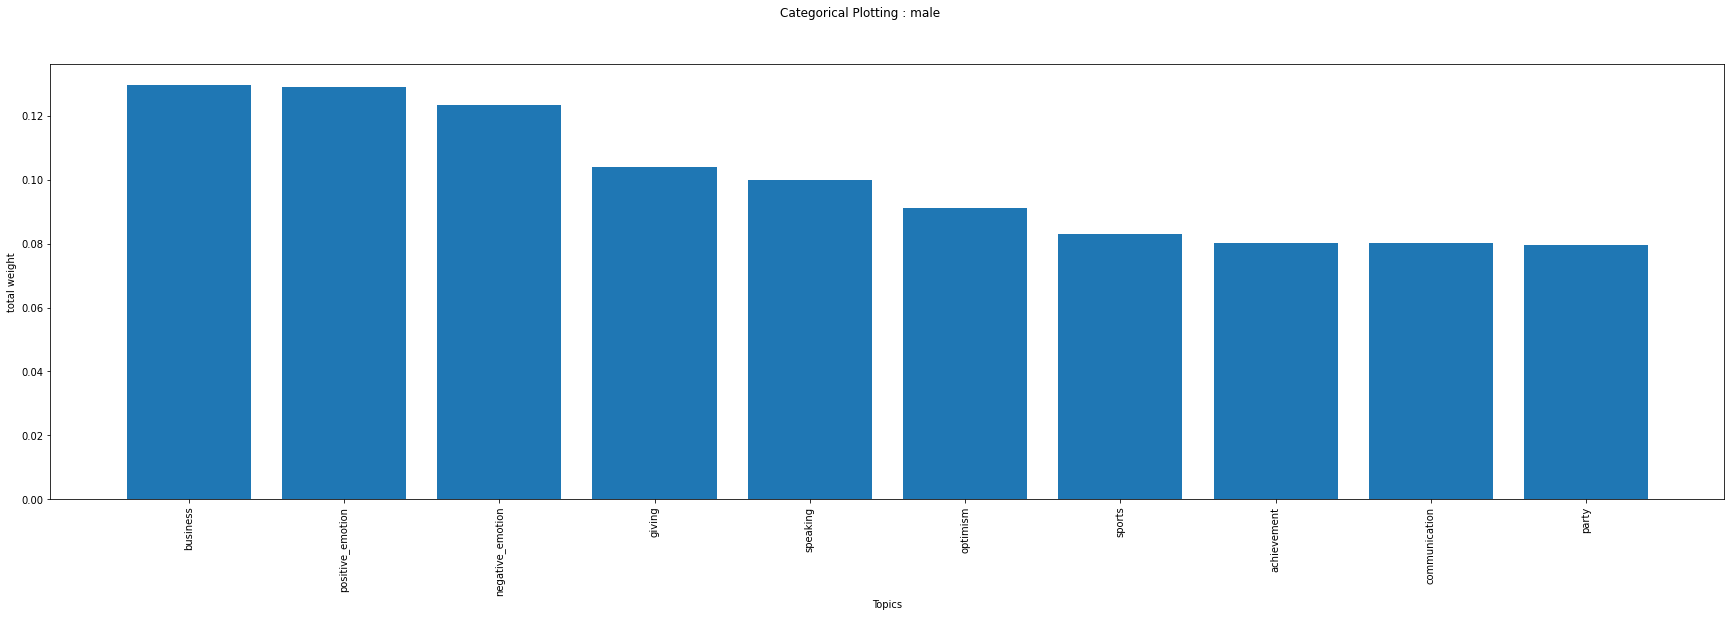

In [53]:
n_most_males_2020 = get_n_most_cited(dict_topics_males_2020, 10, True)
categorical_plot(n_most_males_2020, 'male')

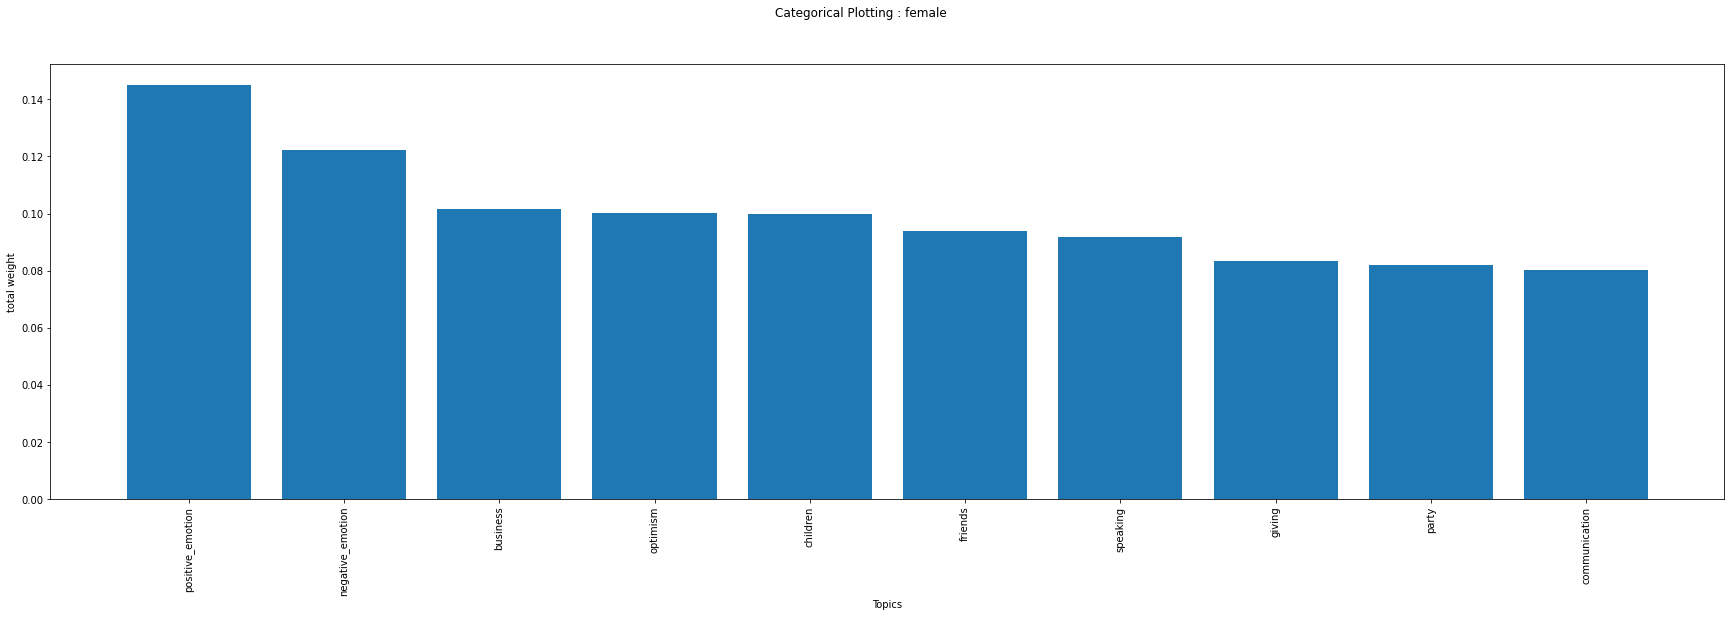

In [54]:
n_most_females_2020 = get_n_most_cited(dict_topics_females_2020, 10, True)
categorical_plot(n_most_females_2020, 'female')

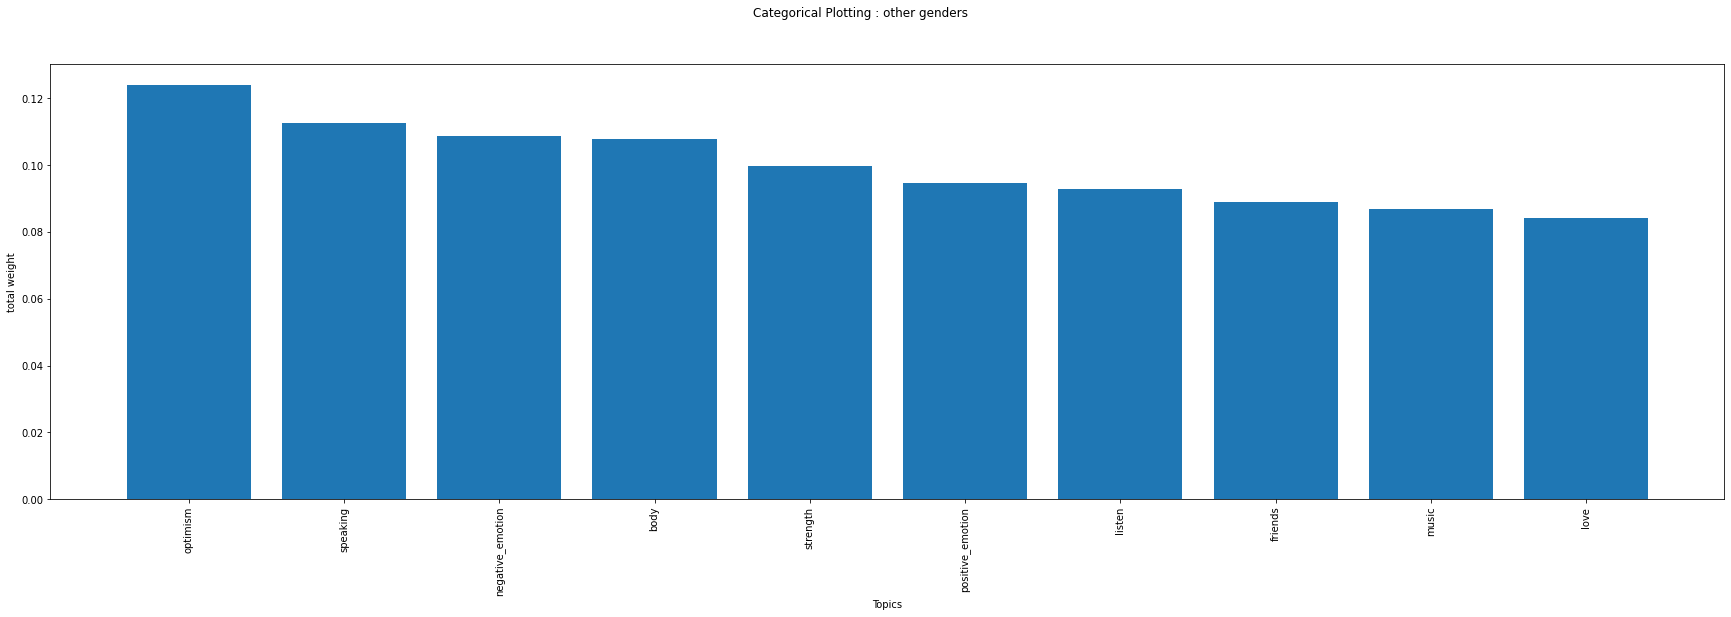

In [55]:
n_most_others_2020 = get_n_most_cited(dict_topics_others_2020, 10, True)
categorical_plot(n_most_others_2020, 'other genders')

In [ ]:
n_most_2020 = [n_most_males_2020, n_most_females_2020, n_most_others_2020]
genders = ['Male', 'Female', 'Other genders']

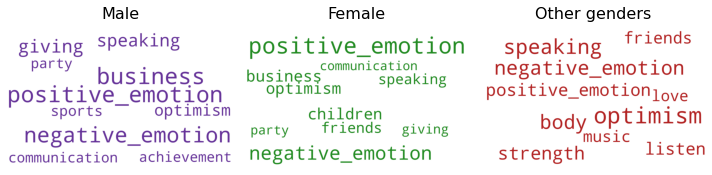

In [57]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = ['rebeccapurple', 'forestgreen', 'firebrick']
fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

cloud = WordCloud(width=3000,
                  height=1900,
                  prefer_horizontal=1.0,
                  max_words=10,
                  background_color='white',
                  relative_scaling = 1,
                  color_func=lambda *args, **kwargs: cols[i])

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = n_most_2020[i]
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(genders[i], fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [13]:
# Normalized value
norm = False

2020

In [14]:
topics_2020_df = pd.read_pickle(QUOTES_TOPICS_2020_PATH)
# Create one topic dictionary per gender
dict_topics_males_2020 = topics_2020_df[topics_2020_df['gender'] == 'male'].topics.values[0]
dict_topics_females_2020 = topics_2020_df[topics_2020_df['gender'] == 'female'].topics.values[0]
dict_topics_others_2020 = topics_2020_df[topics_2020_df['gender'] == 'others'].topics.values[0]
n_most_males_2020 = get_n_most_cited(dict_topics_males_2020, 10, normalized=norm)
n_most_females_2020 = get_n_most_cited(dict_topics_females_2020, 10, normalized=norm)
n_most_others_2020 = get_n_most_cited(dict_topics_others_2020, 10, normalized=norm)

2019

In [15]:
topics_2019_df = pd.read_pickle(QUOTES_TOPICS_2019_PATH)
# Create one topic dictionary per gender
dict_topics_males_2019 = topics_2019_df[topics_2019_df['gender'] == 'male'].topics.values[0]
dict_topics_females_2019 = topics_2019_df[topics_2019_df['gender'] == 'female'].topics.values[0]
dict_topics_others_2019 = topics_2019_df[topics_2019_df['gender'] == 'others'].topics.values[0]
n_most_males_2019 = get_n_most_cited(dict_topics_males_2019, 10, normalized=norm)
n_most_females_2019 = get_n_most_cited(dict_topics_females_2019, 10, normalized=norm)
n_most_others_2019 = get_n_most_cited(dict_topics_others_2019, 10, normalized=norm)

2018

In [16]:
topics_2018_df = pd.read_pickle(QUOTES_TOPICS_2018_PATH)
# Create one topic dictionary per gender
dict_topics_males_2018 = topics_2018_df[topics_2018_df['gender'] == 'male'].topics.values[0]
dict_topics_females_2018 = topics_2018_df[topics_2018_df['gender'] == 'female'].topics.values[0]
dict_topics_others_2018 = topics_2018_df[topics_2018_df['gender'] == 'others'].topics.values[0]
n_most_males_2018 = get_n_most_cited(dict_topics_males_2018, 10, normalized=norm)
n_most_females_2018 = get_n_most_cited(dict_topics_females_2018, 10, normalized=norm)
n_most_others_2018 = get_n_most_cited(dict_topics_others_2018, 10, normalized=norm)

2017

In [17]:
topics_2017_df = pd.read_pickle(QUOTES_TOPICS_2017_PATH)
# Create one topic dictionary per gender
dict_topics_males_2017 = topics_2017_df[topics_2017_df['gender'] == 'male'].topics.values[0]
dict_topics_females_2017 = topics_2017_df[topics_2017_df['gender'] == 'female'].topics.values[0]
dict_topics_others_2017 = topics_2017_df[topics_2018_df['gender'] == 'others'].topics.values[0]
n_most_males_2017 = get_n_most_cited(dict_topics_males_2017, 10, normalized=norm)
n_most_females_2017 = get_n_most_cited(dict_topics_females_2017, 10, normalized=norm)
n_most_others_2017 = get_n_most_cited(dict_topics_others_2017, 10, normalized=norm)

2016

In [18]:
topics_2016_df = pd.read_pickle(QUOTES_TOPICS_2016_PATH)
# Create one topic dictionary per gender
dict_topics_males_2016 = topics_2016_df[topics_2016_df['gender'] == 'male'].topics.values[0]
dict_topics_females_2016 = topics_2016_df[topics_2016_df['gender'] == 'female'].topics.values[0]
dict_topics_others_2016 = topics_2016_df[topics_2016_df['gender'] == 'others'].topics.values[0]
n_most_males_2016 = get_n_most_cited(dict_topics_males_2016, 10, normalized=norm)
n_most_females_2016 = get_n_most_cited(dict_topics_females_2016, 10, normalized=norm)
n_most_others_2016 = get_n_most_cited(dict_topics_others_2016, 10, normalized=norm)

2015

In [19]:
topics_2015_df = pd.read_pickle(QUOTES_TOPICS_2015_PATH)
# Create one topic dictionary per gender
dict_topics_males_2015 = topics_2015_df[topics_2015_df['gender'] == 'male'].topics.values[0]
dict_topics_females_2015 = topics_2015_df[topics_2015_df['gender'] == 'female'].topics.values[0]
dict_topics_others_2015 = topics_2015_df[topics_2015_df['gender'] == 'others'].topics.values[0]
n_most_males_2015 = get_n_most_cited(dict_topics_males_2015, 10, normalized=norm)
n_most_females_2015 = get_n_most_cited(dict_topics_females_2015, 10, normalized=norm)
n_most_others_2015 = get_n_most_cited(dict_topics_others_2015, 10, normalized=norm)

We create a dataframe merging all values of the most cited topics for each year

In [29]:
def get_df_year(dict_males, dict_females, dict_others, year, normalize=False):
  male_df = pd.DataFrame.from_dict(dict_males, orient='index', columns=['weight'])
  male_df['gender'] = 'male'
  female_df = pd.DataFrame.from_dict(dict_females, orient='index', columns=['weight'])
  female_df['gender'] = 'female'
  other_df = pd.DataFrame.from_dict(dict_others, orient='index', columns=['weight'])
  other_df['gender'] = 'others'
  all_df = pd.concat([male_df, female_df,other_df], axis=0)
  all_df['year'] = year

  # Normalize
  if normalize:
    sum_all = all_df.weight.sum()
    all_df['weight'] = all_df['weight']/sum_all
  return all_df

In [30]:
# Normallized value
norm_all = True

In [31]:
all_df_2020 = get_df_year(n_most_males_2020, n_most_females_2020, n_most_others_2020, 2020, normalize=norm_all)
all_df_2019 = get_df_year(n_most_males_2019, n_most_females_2019, n_most_others_2019, 2019, normalize=norm_all)
all_df_2018 = get_df_year(n_most_males_2018, n_most_females_2018, n_most_others_2018, 2018, normalize=norm_all)
all_df_2017 = get_df_year(n_most_males_2017, n_most_females_2017, n_most_others_2017, 2017, normalize=norm_all)
all_df_2016 = get_df_year(n_most_males_2016, n_most_females_2016, n_most_others_2016, 2016, normalize=norm_all)
all_df_2015 = get_df_year(n_most_males_2015, n_most_females_2015, n_most_others_2015, 2015, normalize=norm_all)
all_years_df = pd.concat([all_df_2020, all_df_2019, all_df_2018, all_df_2017, all_df_2016, all_df_2015], axis=0)
all_years_df.shape

(180, 3)

In [67]:
n_most_females_2015

{'business': 0.10601824901798926,
 'children': 0.09918448343899501,
 'communication': 0.08211051463146704,
 'friends': 0.09046682625787403,
 'giving': 0.08528204886027115,
 'negative_emotion': 0.1250109305388104,
 'optimism': 0.1083302770906042,
 'party': 0.08070158680945459,
 'positive_emotion': 0.12785178933573005,
 'speaking': 0.09504329401880411}

In [32]:
all_years_df[all_years_df.year == 2016].head()

,weight,gender,year
positive_emotion,0.099873,male,2016
negative_emotion,0.092783,male,2016
business,0.083760,male,2016
optimism,0.076746,male,2016
achievement,0.076397,male,2016


In [33]:
pd.unique(all_years_df.index.values)


array(['business', 'positive_emotion', 'negative_emotion', 'giving',
       'speaking', 'optimism', 'sports', 'achievement', 'communication',
       'party', 'children', 'friends', 'body', 'strength', 'listen',
       'music', 'love', 'play', 'violence', 'pain', 'fun', 'musical',
       'celebration', 'family', 'money', 'emotional', 'affection',
       'heroic', 'feminine'], dtype=object)

Plots

In [35]:
x = pd.unique(all_years_df.index.values)

y = all_years_df[all_years_df.year == 2015]

y1 = y[y.gender=='male']['weight']
y2 = y[y.gender=='female']['weight']
y3 = y[y.gender=='others']['weight']

fig = go.Figure(go.Bar(x=x, y=y1, name='male'))
fig.add_trace(go.Bar(x=x, y=y2, name='female'))
fig.add_trace(go.Bar(x=x, y=y3, name='other'))

fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'}, title="Total weight distribution of topics per gender in 2015",
                  xaxis_title="Topics", yaxis_title="Total weights",)
fig.show()

In [36]:
x = pd.unique(all_years_df.index.values)

y = all_years_df[all_years_df.year == 2020]

y1 = y[y.gender=='male']['weight']
y2 = y[y.gender=='female']['weight']
y3 = y[y.gender=='others']['weight']

fig = go.Figure(go.Bar(x=x, y=y1, name='male'))
fig.add_trace(go.Bar(x=x, y=y2, name='female'))
fig.add_trace(go.Bar(x=x, y=y3, name='other'))

fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'}, title="Total weight distribution of topics per gender in 2020",
                  xaxis_title="Topics", yaxis_title="Total weights",)
fig.show()

Now let's see the mean distribution over all years

In [48]:
all_years_df['topic'] = all_years_df.index
tmp_df = all_years_df.groupby(['topic','gender'],as_index=False).sum().drop(columns=['year'])
tmp_df['weight'] = tmp_df['weight']/tmp_df.weight.sum()
tmp_df.head()

,topic,gender,weight
0,achievement,male,0.070237
1,affection,others,0.000113
2,body,others,0.000143
3,business,female,0.023149
4,business,male,0.089927


In [49]:
tmp_df.weight.sum()

0.9999999999999999

In [50]:
x = pd.unique(tmp_df.topic)

y = tmp_df.copy()
y1 = y[y.gender=='male']['weight']
y2 = y[y.gender=='female']['weight']
y3 = y[y.gender=='others']['weight']

fig = go.Figure(go.Bar(x=x, y=y1, name='male'))
fig.add_trace(go.Bar(x=x, y=y2, name='female'))
fig.add_trace(go.Bar(x=x, y=y3, name='other'))

fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'}, title="Total weight distribution of topics per gender over all years",
                  xaxis_title="Topics", yaxis_title="Total weights")
fig.show()

In [52]:
year_df = all_years_df.groupby(['topic','gender','year'],as_index=False).sum()
female_quotes = year_df[year_df.gender == 'female']

fig = px.line(female_quotes, x='year', y='weight', color='topic', title="Evolution of most popular topics among women between 2015 and 2020")
fig.show()

In [53]:
male_quotes = year_df[year_df.gender == 'male']

fig = px.line(male_quotes, x='year', y='weight', color='topic', title="Evolution of most popular topics among men between 2015 and 2020")
fig.show()

In [55]:
(year_df[year_df.gender == 'others']['weight'] != 0).any()


True

In [56]:
others_quotes = year_df[year_df.gender == 'others']

fig = px.line(others_quotes, x='year', y='weight', color='topic', title="Evolution of most popular topics among gender minorities between 2015 and 2020")
fig.show()